# 1.神经网络拟合函数

本次作业的第一节，我们的目标是利用torch.nn这一模块实现通过神经网络拟合函数的任务，利用4次多项式函数来拟合余弦函数（定义域：$[-\pi,\pi]$）。
请作图展示拟合后的效果。
同学们可以参考课件的代码完成。

In [1]:
import torch
from torch import nn,optim,flatten
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import math
import numpy as np
from matplotlib import pyplot as plt
torch.manual_seed(1) #设置随机种子以保证实验的可重复性

In [28]:
class Polynomial4(nn.Module):
    def __init__(self):
        super().__init__()
        self.a=nn.Parameter(torch.randn(1))
        self.b=nn.Parameter(torch.randn(1))
        self.c=nn.Parameter(torch.randn(1))
        self.d=nn.Parameter(torch.randn(1))
        self.e=nn.Parameter(torch.randn(1))
        # self.e=0
    def forward(self, x ):
        return self.a+self.b*x+self.c*x**2+self.d*x**3+self.e*x**4
    def __str__(self):
        return 'y=%.3f + %.3f x + %.3f x^2 + %.3f x^3 + %.3f x^4'%(self.a.item(),self.b.item(),self.c.item(),self.d.item(),self.e.item())
    __repr__=__str__

In [29]:
# 请仿照课上的PPT完成训练过程，下面的代码只是作为参考，可以随意修改
# TODO
x = torch.linspace(-math.pi,math.pi,steps = 4000)
y = torch.cos(x)
model = Polynomial4()
optimizer =  optim.SGD(model.parameters(),lr=1e-7)
criterion = nn.MSELoss(reduction='sum')

In [30]:
loss_list=[]
for t in range(20001):
    y_pred=model(x)

    loss=criterion(y_pred,y)
    loss_list.append(loss.item())
    if(t%2000==0):
        print(t,loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 1188158.0
2000 1340.220703125
4000 648.1820068359375
6000 315.81695556640625
8000 154.2766571044922
10000 75.72714233398438
12000 37.52595520019531
14000 18.94619369506836
16000 9.909391403198242
18000 5.5140061378479
20000 3.376171350479126


In [31]:
model

y=0.937 + 0.000 x + -0.429 x^2 + -0.000 x^3 + 0.024 x^4

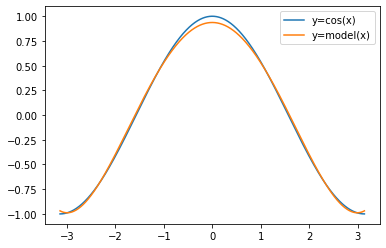

In [34]:
plt.plot(x,y,label="y=cos(x)")
plt.plot(x,y_pred.tolist(),label="y=model(x)")
plt.legend(loc='best')
plt.show()

# 2.卷积神经网络
本节我们将完成关于卷积神经网络的练习。练习分为两部分，首先是简单地手写卷积来完成边缘提取任务，该部分属于传统的图像识别范畴。然后，我们将实现一个卷积神经网络来完成对FashionMINST数据集进行分类的工作。


## 2.1 卷积边缘提取
边缘的特点是像素值在这里会发生跃迁，因此可以通过计算梯度的方式来判定边缘的位置。我们可以利用卷积和特定的算子来计算相邻像素的变化，常用的算子包括Sobel算子、Prewitt算子、Laplacian算子等，同学们也可以自行设计算子来对下面的图片进行边缘检测。
请使用填充保证输入、输出的图像尺寸相等

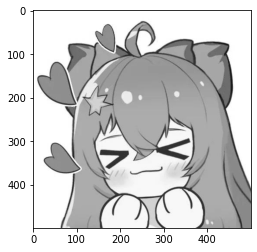

In [35]:
import cv2
diana = cv2.imread('./diana.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(diana,cmap ='gray')
plt.show()

首先我们设计卷积核，注意这里只进行卷积操作，因此不需要保存梯度，然后利用该卷积核进行卷积即可。

关于pytorch的权重初始化，可以参考[这里](https://blog.csdn.net/shanglianlm/article/details/85165523)，不过本次任务实际上我们只需要对weight赋值即可。请注意对nn.Module的weight赋值时需要将tensor转化为nn.Parameter类，否则会报错。同时我们需要对图像的shape进行略微的修改以适应Conv2d的要求

另外卷积后的结果可能会超出灰度图的范围，为了更好的显示效果可能需要后续处理。

In [86]:
class kernel(nn.Module):
    def __init__(self):
        super(kernel,self).__init__()
        # TODO，设计卷积核的格式并将卷积核的权重初始化为指定的内容
        self.conv = nn.Conv2d(1, 1, 3, bias=False)
        self.conv.weight = nn.Parameter(torch.tensor([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], dtype=torch.float32).reshape((1, 1, 3, 3)))
    def forward(self,x):
        # TODO
        return self.conv(x)

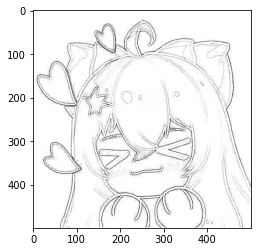

In [162]:
def convolution(image , kernel):
    # TODO
    t1=np.ones((1,image.shape[1]))*255
    t2=np.ones((image.shape[0]+2,1))*255
    tmp_img=np.concatenate([t2,np.concatenate([t1,image,t1]),t2],axis=1)
    tmp=kernel(torch.from_numpy(np.array(tmp_img,dtype='float32').reshape((1,1,tmp_img.shape[0],tmp_img.shape[1]))))
    res=tmp.data.squeeze().numpy()
    res[res<0]=0
    res[res>255]=255
    return 255-res
conv_kernel = kernel()
res = convolution(diana,conv_kernel)
plt.imshow(res,'gray')

## 2.2 基于卷积神经网络的图像分类
本节我们将在FashionMINST数据集上完成简单的图像分类任务，对于网络的设计和最终的分类成绩本次作业没有确切的要求，不过如果稍微调一下参的话取得80%+的正确率应该不算难。

In [132]:
#数据下载，这里可以直接下现成的Dataset，如果同学们想更进一步学习的话应该了解torch.utils.data.Dataset类的写法
training_data = datasets.FashionMNIST(
    root="./", train=True, download=True, transform=ToTensor())
test_data = datasets.FashionMNIST(
    root="./", train=False, download=True, transform=ToTensor())

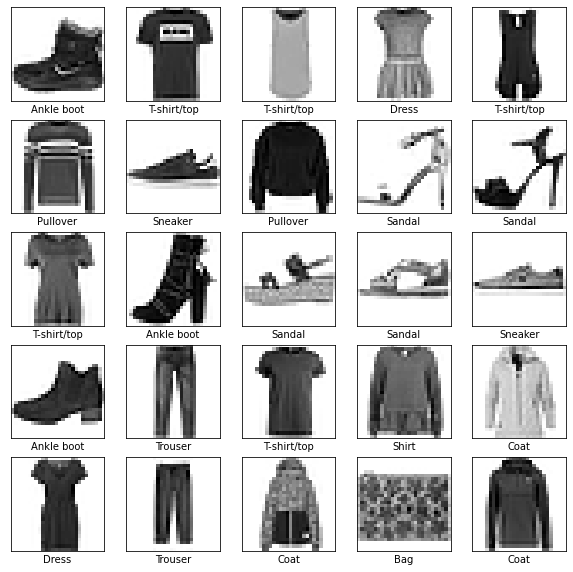

In [133]:
# 进行简单的可视化
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(training_data[i][0].squeeze(0), cmap=plt.cm.binary)
    plt.xlabel(labels[training_data[i][1]])
plt.show()

In [134]:
train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

In [168]:
from collections import OrderedDict

In [257]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        #自行设计神经网络结构
        super(NeuralNetwork,self).__init__()
        self.convnet=nn.Sequential(OrderedDict([
            ('c1',nn.Conv2d(1,6,kernel_size=(5,5))),
            ('relu1',nn.ReLU()),
            ('s2',nn.MaxPool2d(kernel_size=(2,2),stride=2)),
            ('c3',nn.Conv2d(6,16,kernel_size=(5,5))),
            ('relu3',nn.ReLU()),
            ('s4',nn.MaxPool2d(kernel_size=(2,2),stride=2)),
            ('c5',nn.Conv2d(16,120,kernel_size=(4,4))),
            ('relu5',nn.ReLU())
        ]))

        self.fc=nn.Sequential(OrderedDict([
            ('f6',nn.Linear(120,84)),
            ('relu6',nn.ReLU()),
            ('f7',nn.Linear(84,10)),
            ('sig7',nn.LogSoftmax(dim=-1))
        ]))
    def forward(self, x) :
        # raise NotImplementedError
        output=self.convnet(x)
        output=output.view(x.size(0),-1)
        output=self.fc(output)
        return output

In [271]:
net=NeuralNetwork()
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(net.parameters(),lr=1e-4)

In [269]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size=len(dataloader.dataset)
    for batch, (image, label) in enumerate(dataloader):
        # TODO，训练函数
        pred=model(image)
        loss=loss_fn(pred,label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            print("{} / {} , loss: {:.6f}".format(batch*len(label), size, loss.item()))
        # pass
def test_loop(dataloader, model, loss_fn):
    size=len(dataloader.dataset)
    correct=0
    with torch.no_grad():
        for image, label in dataloader:
        #TODO，测试函数
            pred=model(image)
            correct+=(pred.argmax(1)==label).type(torch.float).sum().item()
    correct/=size
    print("Accuracy: {:.2f}%" .format(correct * 100))
    return correct
        # pass

In [272]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    #TODO
    train_loop(train_dataloader,net,criterion,optimizer)
    test_acc=test_loop(test_dataloader,net,criterion)
    if(test_acc>=0.8):
        break
print("训练完成!")

Epoch 1
-------------------------------
0 / 60000 , loss: 2.308207
6400 / 60000 , loss: 2.210349
12800 / 60000 , loss: 1.379429
19200 / 60000 , loss: 1.114958
25600 / 60000 , loss: 0.907096
32000 / 60000 , loss: 0.850224
38400 / 60000 , loss: 0.862597
44800 / 60000 , loss: 0.820173
51200 / 60000 , loss: 0.750256
57600 / 60000 , loss: 0.815742
Accuracy: 70.67%
Epoch 2
-------------------------------
0 / 60000 , loss: 0.720694
6400 / 60000 , loss: 0.802708
12800 / 60000 , loss: 0.588301
19200 / 60000 , loss: 0.818574
25600 / 60000 , loss: 0.767962
32000 / 60000 , loss: 0.707183
38400 / 60000 , loss: 0.715804
44800 / 60000 , loss: 0.664282
51200 / 60000 , loss: 0.675558
57600 / 60000 , loss: 0.718129
Accuracy: 74.08%
Epoch 3
-------------------------------
0 / 60000 , loss: 0.628574
6400 / 60000 , loss: 0.667580
12800 / 60000 , loss: 0.482334
19200 / 60000 , loss: 0.749955
25600 / 60000 , loss: 0.695330
32000 / 60000 , loss: 0.675647
38400 / 60000 , loss: 0.652537
44800 / 60000 , loss: 0.

In [273]:
print("Accuracy: {:.2f}%" .format(test_acc * 100))

Accuracy: 80.25%
